# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [6]:
#Import any view the data 
df = pd.read_csv('zillow_data.csv')
df['State'].value_counts()

CA    1224
NY    1015
TX     989
PA     831
FL     785
OH     588
IL     547
NJ     502
MI     499
NC     428
IN     428
MA     417
TN     404
VA     401
MN     375
GA     345
WA     341
WI     332
MO     319
MD     317
CO     249
KS     241
AZ     230
OR     224
OK     221
SC     206
NH     199
LA     193
AL     183
IA     158
MS     153
KY     139
CT     124
UT     121
ID     110
AR     105
NV     103
ME      86
NE      83
WV      72
MT      71
HI      62
NM      60
RI      59
DE      41
WY      31
ND      31
AK      28
SD      19
DC      18
VT      16
Name: State, dtype: int64

In [7]:
# Any null values?
df_desc = df.isnull().describe()
df_desc.iloc[[0,3]]
df_desc= df_desc.append(df_desc.iloc[0] - df_desc.iloc[3],ignore_index=True)
df_desc['index'] = pd.Series(['count', 'unique', 'top', 'non-nulls', 'nulls'])
df_desc = df_desc.set_index(df_desc['index'])
df_desc.drop('index',axis=1,inplace=True)

df_desc.iloc[[0,3,4]]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
index,,,,,,,,,,,,,,,,,,,,,
count,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723,...,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723
non-nulls,14723,14723,14723,14723,13680,14723,14723,13684,13684,13684,...,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723
nulls,0,0,0,0,1043,0,0,1039,1039,1039,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# How many nulls in total?
tot_values = df_desc.iloc[0].sum()
num_null_values = tot_values -df_desc.iloc[3].sum()

print("Total number of entries: {}\nTotal number of null entries: {}".format(tot_values,num_null_values))
print("{}% of values are nulls".format(round(num_null_values/tot_values*100,3)))

Total number of entries: 4004656
Total number of null entries: 157934
3.944% of values are nulls


In [9]:
# Example of a row with NaNs before cleaning 
df.iloc[[20]]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300


In [10]:
#And after cleaning
df.fillna(0,inplace=True)
df.iloc[[20]]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,61625,10011,New York,NY,New York,New York,21,0.0,0.0,0.0,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300


In [11]:
df.isnull().describe().iloc[[0,3]]


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723,...,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723
freq,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723,...,14723,14723,14723,14723,14723,14723,14723,14723,14723,14723


In [12]:
import seaborn as sns
%matplotlib inline

# df['RegionID']
df_plot = df.drop(['RegionName','City','Metro','CountyName','SizeRank'],axis=1)
df_plot.set_index('RegionID',inplace=True)
df_plot

,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionID,,,,,,,,,,,,,,,,,,,,,
84654,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
90668,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
91982,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
84616,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
93144,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58333,MA,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
59107,NH,92700.0,92500.0,92400.0,92200.0,92100.0,91900.0,91700.0,91300.0,90900.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
75672,KY,57100.0,57300.0,57500.0,57700.0,58000.0,58200.0,58400.0,58700.0,59100.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400


In [13]:
x= df_plot.loc[(df_plot['State']== 'MA')]

In [14]:
# x[x.index == 84298]
x

,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionID,,,,,,,,,,,,,,,,,,,,,
58669,MA,137800.0,137900.0,137900.0,138000.0,138100.0,138200.0,138400.0,138600.0,139100.0,...,416900,417800,421100,425100,428600,431900,435700,440500,445800,449100
58660,MA,130600.0,130700.0,130800.0,131000.0,131200.0,131400.0,131800.0,132200.0,132700.0,...,439100,442400,446700,451400,454700,457700,461900,466000,469300,471100
58666,MA,157100.0,157300.0,157500.0,157800.0,158100.0,158500.0,158900.0,159300.0,159900.0,...,564500,570100,576400,582800,588600,594700,602100,609000,613300,614800
58743,MA,125900.0,126200.0,126500.0,126700.0,126800.0,127000.0,127300.0,127700.0,128300.0,...,340100,341700,344900,347200,349000,351300,354400,356800,358300,358400
58710,MA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,277700,279500,283300,287200,290200,293000,295900,298900,301700,302600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58212,MA,91200.0,91100.0,91000.0,90800.0,90700.0,90600.0,90600.0,90600.0,90700.0,...,193400,195900,200800,202600,201800,201200,204600,211200,217900,220800
58351,MA,88000.0,88000.0,88000.0,88000.0,87900.0,87900.0,87900.0,88000.0,88200.0,...,186700,190600,193400,195000,196700,198800,200600,202400,204600,206300
58316,MA,124700.0,125100.0,125500.0,126000.0,126400.0,126800.0,127200.0,127500.0,127700.0,...,246100,246200,245700,245000,243800,242100,242300,245300,248500,250100


In [15]:
x.drop('State',axis=1,inplace=True)

/Users/ranykhalil/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
column_names = x.columns.tolist()
df_diff = pd.DataFrame({})
for index, item in enumerate(column_names[1:]):
    new_column = "(" + item + ")-(" + column_names[index] + ")"
#    df_diff[new_column] = (x[item] - x[column_names[index]])*100/(x[column_names[index]])
#     df_diff[new_column] = np.log(x[item]) - np.log(x[column_names[0]]) # as % plot
#     df_diff[new_column] = np.log(x[item]) - np.log(x[column_names[index]]) # as returns
    df_diff[new_column] = (x[item] - x[column_names[index]])*100/ (x[column_names[index]])

# df_diff
# df_diff = scaler.fit_transform(df_diff)

df_diff.fillna(0,inplace=True)
# df_diff = scaler.fit_transform(df_diff)
# df_diff.min()
df_diff.describe()
df_diff.iloc[4].tail(50).sum()
# .sum()
# plt.scatter(df_diff.describe().iloc[6],df_diff.columns)

#     df_diff[new_column] = column_names[item] - column_names[index] 
# df_diff 

43.18277348307508

In [17]:
# df_diff= df_diff.loc[:, '(2004-01)-(2003-12)':]

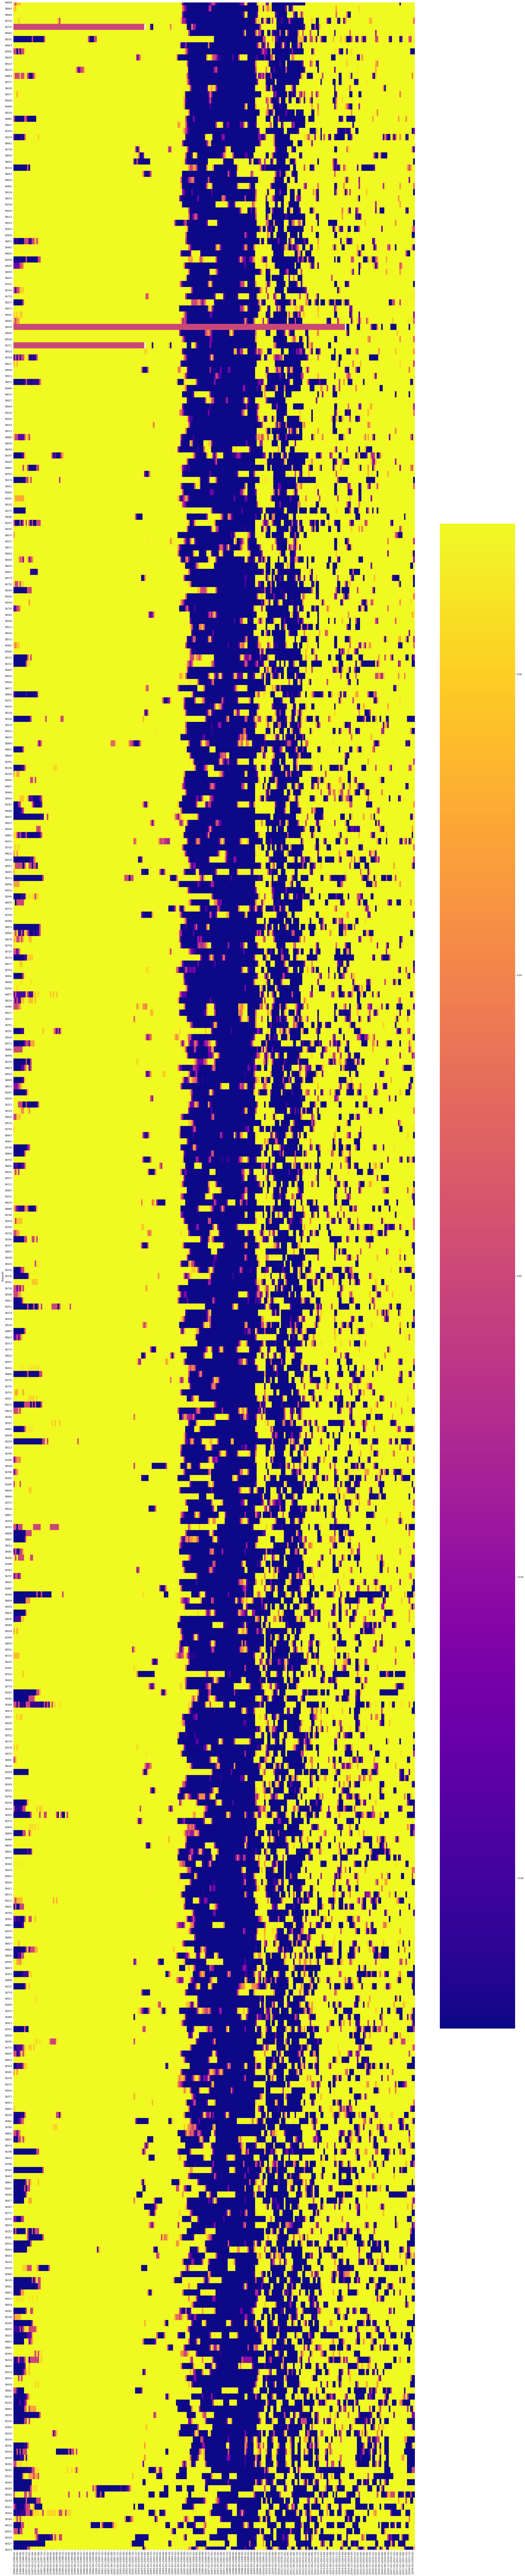

In [18]:
# sns.heatmap(df.iloc[:30])
plt.figure(figsize=(40, len(df_diff)/2))
sns.heatmap(df_diff,cmap="plasma")


# Step 2: Data Preprocessing

In [564]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [19]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [25]:
df_plot.drop('State',axis=1,inplace=True)

In [27]:
melt_data(df_plot)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['City', 'CountyName', 'Metro', 'RegionName', 'State']"

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results